In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
#train_region = "Austin"
#test_region = "SanDiego"
test_region = "Austin"
train_region = "SanDiego"
out_overall = pickle.load(open('../data/input/all_regions.pkl','r'))

train_df = out_overall[train_region]
test_df = out_overall[test_region]
#transform = "DD"
k=3
transformations = ["None","DD","DD-percentage",'median-aggregate',"median-aggregate-percentage",'regional','regional-percentage']
#transformations = ['DD','None',"DD-fridge"]

In [3]:
out = {}
for transform in transformations:
    out[transform] = {}
    #for appliance in ["hvac","fridge","dr","wm"]:
    for appliance in ['hvac','fridge','wm']:
        out[transform][appliance] = {}
        for month in range(1,13):
            print appliance, month, transform
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    out[transform][appliance][month].append(percentage_accuracy)
                except Exception, e:
                    pass

            


hvac 1 None
hvac 2 None
hvac 3 None
hvac 4 None
hvac 5 None
hvac 6 None
hvac 7 None
hvac 8 None
hvac 9 None
hvac 10 None
hvac 11 None
hvac 12 None
fridge 1 None
fridge 2 None
fridge 3 None
fridge 4 None
fridge 5 None
fridge 6 None
fridge 7 None
fridge 8 None
fridge 9 None
fridge 10 None
fridge 11 None
fridge 12 None
wm 1 None
wm 2 None
wm 3 None
wm 4 None
wm 5 None
wm 6 None
wm 7 None
wm 8 None
wm 9 None
wm 10 None
wm 11 None
wm 12 None
hvac 1 DD
hvac 2 DD
hvac 3 DD
hvac 4 DD
hvac 5 DD
hvac 6 DD
hvac 7 DD
hvac 8 DD
hvac 9 DD
hvac 10 DD
hvac 11 DD
hvac 12 DD
fridge 1 DD
fridge 2 DD
fridge 3 DD
fridge 4 DD
fridge 5 DD
fridge 6 DD
fridge 7 DD
fridge 8 DD
fridge 9 DD
fridge 10 DD
fridge 11 DD
fridge 12 DD
wm 1 DD
wm 2 DD
wm 3 DD
wm 4 DD
wm 5 DD
wm 6 DD
wm 7 DD
wm 8 DD
wm 9 DD
wm 10 DD
wm 11 DD
wm 12 DD
hvac 1 DD-percentage
hvac 2 DD-percentage
hvac 3 DD-percentage
hvac 4 DD-percentage
hvac 5 DD-percentage
hvac 6 DD-percentage
hvac 7 DD-percentage
hvac 8 DD-percentage
hvac 9 DD-percentage
h

In [4]:
acc = {tr:{} for tr in transformations}

acc['Regional average']={}

for transform in transformations:
    for appliance in ["hvac","fridge","wm"]:
    #for appliance in ["hvac"]:    
        acc[transform][appliance] = {}
        for month in range(1,13):
            acc[transform][appliance][month] = pd.Series(out[transform][appliance][month]).mean()

In [5]:
%matplotlib inline

In [6]:
contri = {
    'Austin':
    {'Cooling':{'wm':0.01,
    'hvac':0.29,
    'fridge':0.09},
    'Heating':
    {'wm':.01,'hvac':0.07,'fridge':0.09}}
    
    ,
    'SanDiego':
    {'wm':0.01,
    'hvac':.16,
    'fridge':0.15}
}

In [7]:
for appliance in ["hvac",'fridge','wm']:
    acc['Regional average'][appliance] = {}
    for month in range(1,13):
        acc['Regional average'][appliance][month] = []
        for test_home in test_df.index:
            try:
                if month in range(3, 11):
                    pred = test_df.ix[test_home]['aggregate_%d' %month]*contri[test_region]['Cooling'][appliance]
                else:
                    pred = test_df.ix[test_home]['aggregate_%d' %month]*contri[test_region]['Heating'][appliance]
                gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                error = np.abs(gt-pred)
                percentage_error = error*100/gt
                if percentage_error>100:
                    percentage_error=100
                percentage_accuracy = 100-percentage_error
                acc['Regional average'][appliance][month].append(percentage_accuracy)
            except Exception, e:
                print e
                
        acc['Regional average'][appliance][month] = pd.Series(acc['Regional average'][appliance][month]).mean()

In [8]:
best_transform = {}
for appliance in ['hvac','fridge','wm']:
    best = 0
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop =1, 13
    for transform in transformations:
        if pd.DataFrame(acc[transform])[appliance][start:stop].mean()>best:
            best = pd.DataFrame(acc[transform])[appliance][start:stop].mean()
            best_transform[appliance] = transform    

In [9]:
best_transform

{'fridge': 'regional', 'hvac': 'DD-percentage', 'wm': 'regional'}

In [10]:
import pickle
lbm_results = pickle.load(open('../data/output/lbm-main.pkl','r'))

In [17]:
results = {}
results['EnerScale'] = {}
results['Regional average'] = {}
results['NILM'] = {}

for appliance in ['fridge','hvac','wm']:
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop =1, 13
    results['EnerScale'][appliance] = pd.Series(acc[best_transform[appliance]][appliance])[start:stop].mean()
    results['Regional average'][appliance] = pd.Series(acc["Regional average"][appliance])[start:stop].mean()
    results['NILM'][appliance]  = lbm_results[test_region][appliance]

In [18]:
result_df_austin = pd.DataFrame(results)

In [20]:
result_df_austin = result_df_austin[['Regional average','NILM','EnerScale']]

In [21]:
result_df_austin.index = ['Fridge','HVAC','Washing\nmachine']

In [22]:
result_df_austin

,Regional average,NILM,EnerScale
Fridge,51.605550,68.109587,69.735000
HVAC,57.554688,45.053749,61.758546
Washing\nmachine,20.659622,38.346676,48.775716


In [23]:
import sys


In [24]:
sys.path.append('../code/')

In [25]:
from common_functions import latexify, format_axes, tableau20blind

In [26]:
latexify()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [27]:
import matplotlib.pyplot as plt

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


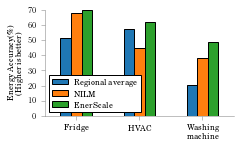

In [28]:
ax = result_df_austin.plot(colors=tableau20blind[::2], kind="bar",rot=0)
ax.legend(loc=3)
format_axes(ax)
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)")
plt.tight_layout()

plt.savefig('../results/main_sd_austin.pdf',bbox_inches="tight")
plt.savefig('../results/main_sd_austin.png',bbox_inches="tight")

In [70]:
import matplotlib.pyplot as plt

In [372]:
acc['Regional average'].keys()

['hvac']

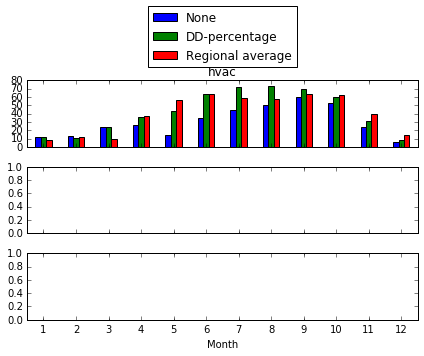

In [374]:
fig, ax = plt.subplots(nrows=3, sharex=True)
#for i, appliance in enumerate(["hvac","fridge","wm"]):
for i, appliance in enumerate(["hvac"]):

    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df = df[['None','DD-percentage','Regional average']]
    df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
plt.tight_layout()
lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
plt.xlabel("Month")
#plt.savefig('../results/dd_transform_sd_austin.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

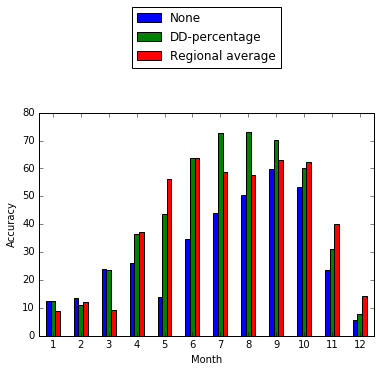

In [375]:
df.plot(kind="bar",rot=0)
plt.xlabel("Month")
plt.ylabel("Accuracy")
lgd=plt.legend(bbox_to_anchor=(0.5,1.5), loc='upper center', ncol=1)
plt.savefig('../results/dd_transform_sd_austin_hvac.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [369]:
df.ix[range(5,11)].mean()

DD                  55.167269
None                42.738050
median-aggregate    50.293532
DD-percentage       63.868075
regional            45.371368
dtype: float64

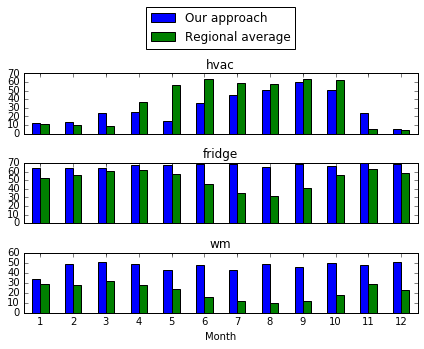

In [157]:
from IPython.display import Image
Image('../results/no_transform_sd_austin.png')

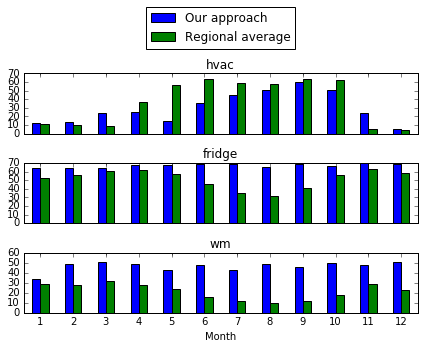

In [119]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for i, appliance in enumerate(["hvac","fridge","wm"]):
    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
plt.tight_layout()
lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
plt.xlabel("Month")
#

#plt.savefig('../results/no_transform_sd_austin.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [73]:
ap_dict

{'Our approach': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236},
 'Regional average': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236}}

In [77]:
acc['Regional average']

{'fridge': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'hvac': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'wm': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []}}

In [129]:
train_df['hvac_9'].mean()

218.4750300575705

In [128]:
test_df['hvac_9'].mean()

482.0247721723813

In [245]:
m = {}
for transform in transformations:
    m[transform] = {}
    for appliance in ["fridge"]:
       
        for month in range(1,13):
            m[transform][month]=[]
            
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    #print appliance, month, transform, gt-pred
                    m[transform][month].append(gt-pred)
                except Exception, e:
                    pass

            


In [246]:
pd.Series(m['DD'][7]).describe()

count    299.000000
mean       6.553594
std       32.121251
min      -57.424472
25%       -9.852161
50%        2.342088
75%       14.932602
max      328.898272
dtype: float64

In [247]:
a = {}
for transform in transformations:
    a[transform] = {}
    for month in range(1,13):
        a[transform][month] = pd.Series(m[transform][month]).mean()
    
    

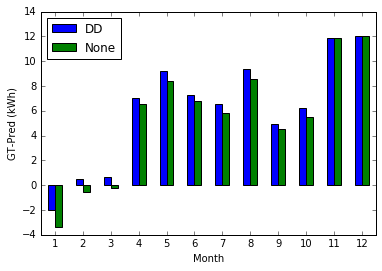

In [250]:
pd.DataFrame(a)[['DD','None']].plot(kind="bar",rot=0)
plt.xlabel("Month")
plt.ylabel("GT-Pred (kWh)")
#plt.savefig('../results/transform_strategy_hvac.png')

In [243]:
train_df['fridge_11'].mean(), test_df['fridge_11'].mean()

(36.504466090883525, 54.91064814108161)

46.137905111303894

In [347]:
out = {}
for transform in transformations:
    out[transform] = {}
    #for appliance in ["hvac","fridge","dr","wm"]:
    for appliance in ['hvac']:
        out[transform][appliance] = {}
        for month in range(1,13):
            print appliance, month, transform
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    
                    out[transform][appliance][month].append(error)
                except Exception, e:
                    pass

            


hvac 1 DD
hvac 2 DD
hvac 3 DD
hvac 4 DD
hvac 5 DD
hvac 6 DD
hvac 7 DD
hvac 8 DD
hvac 9 DD
hvac 10 DD
hvac 11 DD
hvac 12 DD
hvac 1 None
hvac 2 None
hvac 3 None
hvac 4 None
hvac 5 None
hvac 6 None
hvac 7 None
hvac 8 None
hvac 9 None
hvac 10 None
hvac 11 None
hvac 12 None
hvac 1 median-aggregate
hvac 2 median-aggregate
hvac 3 median-aggregate
hvac 4 median-aggregate
hvac 5 median-aggregate
hvac 6 median-aggregate
hvac 7 median-aggregate
hvac 8 median-aggregate
hvac 9 median-aggregate
hvac 10 median-aggregate
hvac 11 median-aggregate
hvac 12 median-aggregate
hvac 1 DD-percentage
hvac 2 DD-percentage
hvac 3 DD-percentage
hvac 4 DD-percentage
hvac 5 DD-percentage
hvac 6 DD-percentage
hvac 7 DD-percentage
hvac 8 DD-percentage
hvac 9 DD-percentage
hvac 10 DD-percentage
hvac 11 DD-percentage
hvac 12 DD-percentage


In [348]:
acc = {tr:{} for tr in transformations}

acc['Regional average']={}

for transform in transformations:
    #for appliance in ["hvac","fridge","wm"]:
    for appliance in ["hvac"]:    
        acc[transform][appliance] = {}
        for month in range(1,13):
            acc[transform][appliance][month] = pd.Series(out[transform][appliance][month]).median()

,DD,DD-percentage,None,Regional average,median-aggregate
hvac,"{1: 8.44147178069, 2: 57.656674514, 3: 44.0356...","{1: 12.0296812273, 2: 48.8202568568, 3: 44.856...","{1: 2.92191117009, 2: 16.5883969124, 3: 42.407...",NaN,"{1: 1.22682088274, 2: 4.71549728458, 3: 40.347..."


In [354]:
pd.Series(acc['DD-percentage']['hvac'])

1     12.029681
2     48.820257
3     44.856039
4     55.901814
5     92.348637
6     81.464455
7     82.482646
8     79.634070
9     71.332982
10    68.626646
11    19.807754
12     7.320005
dtype: float64

In [355]:
pd.Series(acc['None']['hvac'])

1       2.921911
2      16.588397
3      42.407613
4      64.840691
5     155.903642
6     202.587438
7     330.707652
8     326.625814
9     148.695028
10     87.474467
11     21.282795
12      8.047367
dtype: float64